In [2]:
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
import os, sys
from math import floor

sys.path.append("code/")
from training import create_checkpoint_filename
from check_model import compute_skill


In [21]:
#updates parameter tuple and resets the network
def increment_parameter_tuple(p_before,sliding_window=False):
  fn_before = create_checkpoint_filename(p_before)
  p_new=list(p_before)
  p_new[start_day_postion_in_the_list]=p_new[start_day_postion_in_the_list]+training_step_length
  if sliding_window:
    p_new[training_step_length_position]=p_new[training_step_length_position]+training_step_length
  p_new=tuple(p_new)
  fn_new = create_checkpoint_filename(p_new)
  return p_new


In [4]:
def moveav(data, window_length=3):
    tmp1=np.convolve(data, np.ones(window_length), 'same') 
    tmp2 = np.convolve(np.ones(len(data)), np.ones(window_length), 'same')
    tmp = tmp1/tmp2
    return tmp

In [22]:
#load skills
def load_skills(param_list,ts,number_of_training_steps,wds,rdir,sliding_window=False):
    skills = np.empty((len(ts), number_of_training_steps, len(wds)))

    ptmp=list(param_list[0])
    ptmp[start_day_postion_in_the_list]=starting_step
    ptmp=tuple(ptmp)
    for step in range(number_of_training_steps):
        param_list_new=[]
        for w in range(len(wds)):
            ptmp=param_list[w]
            fntmp1 = create_checkpoint_filename(ptmp)
            fntmp2 = os.path.join(rdir,'skill_'+os.path.split(fntmp1)[-1]+'.npy')
            skills[:, step, w]=np.load(fntmp2)

            #increment parameter tuple in time
            param_list_new.append( increment_parameter_tuple(ptmp,sliding_window) )
        param_list=param_list_new
    return skills


In [6]:
def smooth_weeks12_skils(skills,ts,training_step_length):
    number_of_training_steps=skills.shape[1]
    
    ts_step=np.empty((number_of_training_steps,2,))
    ts_step[:]=np.nan
    skill_step=np.empty((number_of_training_steps,2,))
    skill_step[:]=np.nan
    
    for step in range(number_of_training_steps):
        start=starting_step+(training_step_length*step)+0.25
    
        idx_test=np.where( (ts>=start+training_step_length) & (ts<(start+training_step_length+14)) )
        ts_step[step,0]=np.nanmean(ts[idx_test])
        if len(idx_test[0])>1:
            skill_step[step,0] = np.nanmean(np.ndarray.flatten(skills[idx_test[0],step,0]))
                        
        idx_test=np.where( (ts>=start+training_step_length+14) & (ts<(start+training_step_length+28)) )
        ts_step[step,1]=np.nanmean(ts[idx_test])
        if len(idx_test[0])>1:
            skill_step[step,1] = np.nanmean(np.ndarray.flatten(skills[idx_test[0],step,0]))
    return ts_step, skill_step


In [7]:
#paramenter block 
varn='t'


In [17]:
#load truth
y = np.load('npys/y_'+varn+'.npy')
ts = np.arange(y.shape[0])/4

In [35]:
#load linear baseline skill
skill_linear =np.load('npys/skill_linear_t_365_365.npy')
ts_linear = np.arange(skill_linear.shape[0])/4

In [37]:
#load nn trained with 365 days
skill_nn365 = np.load(f'npys/skill_conv2d_{varn}_4_1_4096_3_0.25_32_mse_0.0001_1.0_366_365_0.7.npy')
ts_nn365 = np.arange(skill_nn365.shape[0])/4

In [18]:
#First experiment 
training_step_length=7
start_day_postion_in_the_list=-3
starting_step = 365
number_of_training_steps = 104
#number_of_training_steps = floor((455-starting_step)/training_step_length)
rdir='../tmp_stefan_replay/npys/'

#create parameter tuples
p=list(('t', 4, '1', '4096', 3, 0.25, 32, 'wnew', 0.0001, 1e-5, starting_step, training_step_length, 0.7))
param_list=[]
param_list.append(tuple(p))
wds=[1e-5]

skills_1 = load_skills(param_list,ts,number_of_training_steps,wds,rdir)
ts_step_1, smooth_skills_1=smooth_weeks12_skils(skills_1,ts,training_step_length)

/tmp/ipykernel_278200/3032275483.py:18: RuntimeWarning: Mean of empty slice
  ts_step[step,1]=np.nanmean(ts[idx_test])


In [25]:
#second experiment 
training_step_length=7
training_step_length_position=-2
start_day_postion_in_the_list=-3
starting_step = 365
number_of_training_steps = 103
wds=[ 0.0001]
rdir='npys'

#create parameter tuples
wds_postion_in_the_list = -5
p=list(('t', 4, '1', '4096', 3, 0.25, 32, 'wnew', 0.0001, 1e-5, starting_step, training_step_length, 0.7))
param_list=[]
for w in wds:
  p[wds_postion_in_the_list]=w
  param_list.append(tuple(p))

skills_2 = load_skills(param_list,ts,number_of_training_steps,wds,rdir,True)
ts_step_2, smooth_skills_2=smooth_weeks12_skils(skills_2,ts,training_step_length)

/tmp/ipykernel_278200/3032275483.py:18: RuntimeWarning: Mean of empty slice
  ts_step[step,1]=np.nanmean(ts[idx_test])


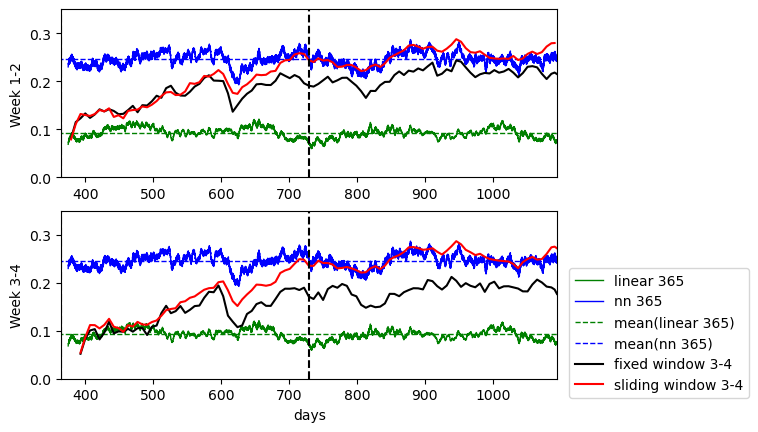

In [46]:
smooth=9

fig, ax = plt.subplots(2,1)

#week 1-2
idx_test=np.where( (ts>=375) )
ax[0].plot(ts_linear[idx_test], moveav(skill_linear[idx_test],smooth), color='g',linewidth=1, label='linear 365')
ax[0].plot(ts_nn365[idx_test], moveav(skill_nn365[idx_test],smooth), color='b',linewidth=1, label='nn 365')
ax[0].plot([0, 365*3], np.mean(skill_linear[idx_test])*np.array([1, 1]), 'g--',linewidth=1, label='mean(linear 365)')
ax[0].plot([0, 365*3], np.mean(skill_nn365[idx_test])*np.array([1, 1]), 'b--',linewidth=1, label='mean(nn 365)')
ax[0].plot(ts_step_1[:,0], smooth_skills_1[:,0], 'k', label='fixed window 1-2')
ax[0].plot(ts_step_2[:,0], smooth_skills_2[:,0], 'r', label='sliding window 1-2')
ax[0].set_ylabel('Week 1-2')
ax[0].plot([365, 365],[0, 1],'k--')
ax[0].plot([365*2, 365*2],[0, 1],'k--')
ax[0].set_ylim(0,0.35)
ax[0].set_xlim(365,365*3)

ax[1].plot(ts_linear[idx_test], moveav(skill_linear[idx_test],smooth), color='g',linewidth=1, label='linear 365')
ax[1].plot(ts_nn365[idx_test], moveav(skill_nn365[idx_test],smooth), color='b',linewidth=1, label='nn 365')
ax[1].plot([0, 365*3], np.mean(skill_linear[idx_test])*np.array([1, 1]), 'g--',linewidth=1, label='mean(linear 365)')
ax[1].plot([0, 365*3], np.mean(skill_nn365[idx_test])*np.array([1, 1]), 'b--',linewidth=1, label='mean(nn 365)')
ax[1].plot(ts_step_1[:,1], smooth_skills_1[:,1], 'k', label='fixed window 3-4')
ax[1].plot(ts_step_2[:,1], smooth_skills_2[:,1], 'r', label='sliding window 3-4')

ax[1].plot([365, 365],[0, 1],'k--')
ax[1].plot([365*2, 365*2],[0, 1],'k--')

ax[1].set_xlabel('days')
ax[1].set_ylabel('Week 3-4')
ax[1].set_ylim(0,0.35)
ax[1].set_xlim(365,365*3)
ax[1].legend(bbox_to_anchor=(1.01, 0.7))



In [42]:
[ts_linear.shape, ts.shape, ts_nn365.shape]

[(4383,), (4383,), (4383,)]